In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, PrecisionRecallDisplay, precision_recall_curve
from scikitplot.metrics import plot_lift_curve, plot_cumulative_gain


In [6]:
# data collection
dataset_file = "D:\manualCDmanagement\codes\Projects\VMs\skl algorithms\Logistic Regression/00_datasets\Airline.1"
file_name = "Airline_customer_satisfaction.csv"
file_path = os.path.join(dataset_file, file_name)
df = pd.read_csv(file_path)

In [7]:
# data cleaning, try one-hot later

df['satisfaction'], _ = pd.factorize(df['satisfaction'])
df['Customer Type'], _ = pd.factorize(df['Customer Type'])
df['Type of Travel'], _ = pd.factorize(df['Type of Travel'])
df['Class'], _ = pd.factorize(df['Class'])


In [8]:
# splitting
X = df.drop('satisfaction', axis=1)
y = df['satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Another data cleaning (imputing)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [10]:
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [11]:
# balancing
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_scaled_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train); y_train_resampled.value_counts()

satisfaction
0    56786
1    47118
Name: count, dtype: int64


satisfaction
0    56786
1    56786
Name: count, dtype: int64

In [12]:
# model creation
model = LogisticRegression(max_iter=3000, random_state=42, class_weight='balanced')
model.fit(X_train_scaled_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced', max_iter=3000, random_state=42)

In [13]:
#model evaluation
y_prob = model.predict_proba(X_test_scaled)
y_prob_positive_class = y_prob[:, 1]

y_test_binary = (y_test == 1)
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob_positive_class)

desired_tpr = 0.7
closest_index = np.argmin(np.abs(tpr - desired_tpr))
threshold_for_tpr = thresholds[closest_index]
# j_scores = tpr - fpr
# optimal_index = np.argmax(j_scores)
# optimal_threshold = thresholds[optimal_index]

threshold =  0.7
y_pred = (y_prob_positive_class >= desired_tpr).astype(int)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[12851  1450]
 [ 3719  7956]]


<Axes: >

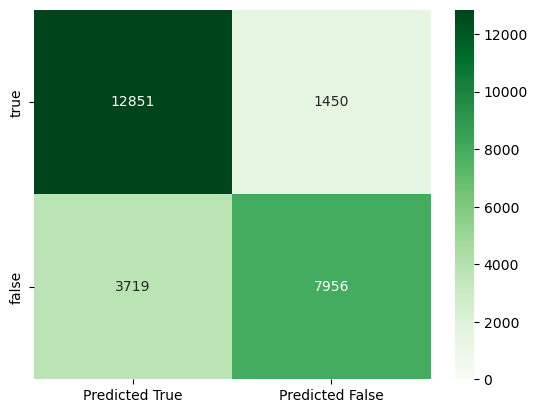

In [14]:
# sns.heatmap(cm, annot=True, fmt='g',xticklabels=['Predicted True', 'Predicted False'], yticklabels=['true', 'false'], vmin=0, cmap='Purples', linewidths=.5, square=True)
sns.heatmap(cm, annot=True, fmt='g',xticklabels=['Predicted True', 'Predicted False'], yticklabels=['true', 'false'], vmin=0, cmap='Greens') # conf matrix

Text(0.5, 1.0, 'ROC Curve')

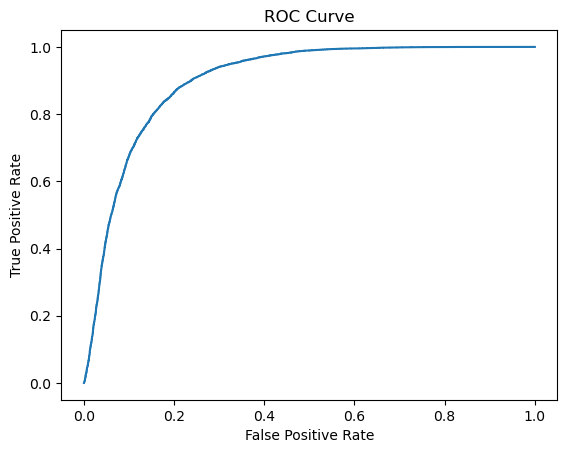

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_prob_positive_class)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

Text(0.5, 1.0, 'Precision-Recall Curve')

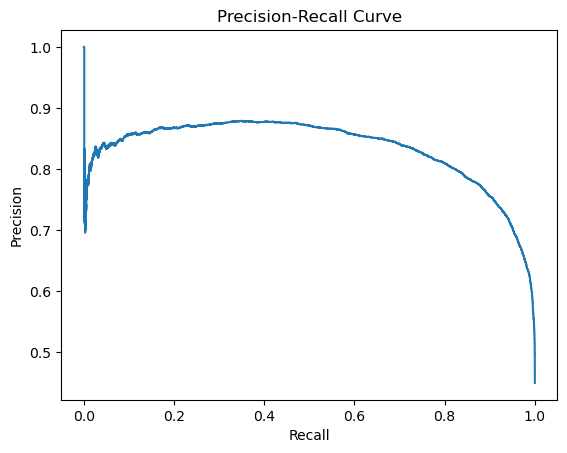

In [16]:
precision, recall, _ = precision_recall_curve(y_test, y_prob_positive_class)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

Text(0.5, 1.0, 'Calibration Curve')

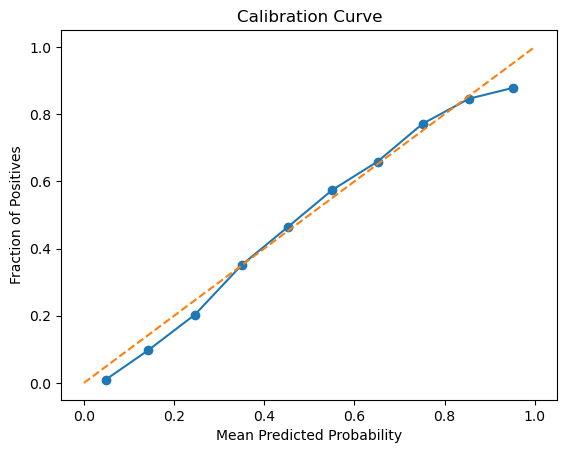

In [19]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_positive_class, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')

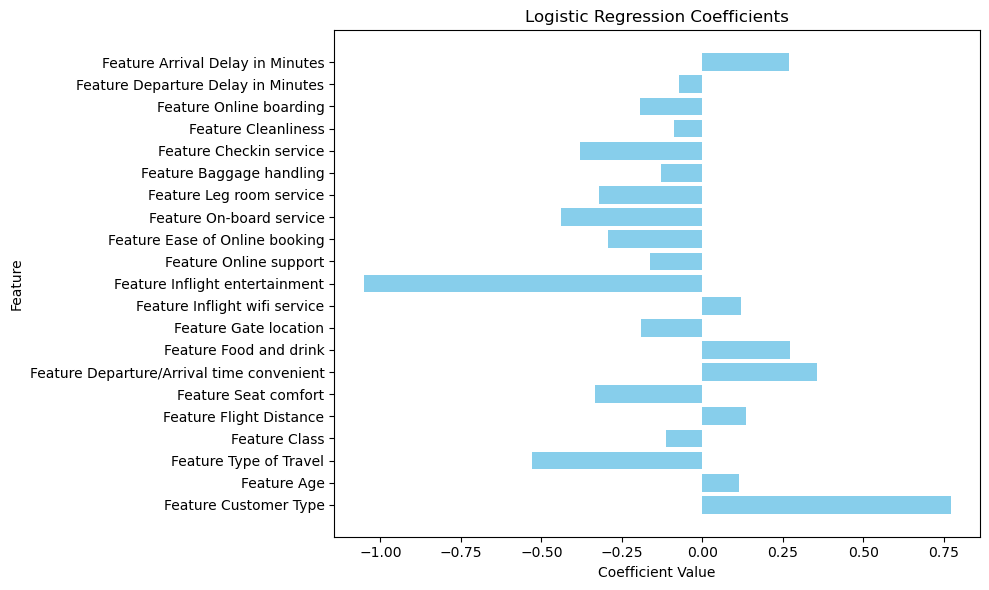

In [36]:
coefficients = model.coef_[0]
feature_names = [f'Feature {i}' for i in X.columns]  # Construct feature names

plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.tight_layout()

save_path = "D:\manualCDmanagement\codes\Projects\VMs\skl algorithms\Logistic Regression/Airline/Figures"
savename = 'coefficisnts.png'
save_this = os.path.join(save_path, savename)
plt.savefig(save_this)